# Ordinal Regression

## Motivation

In order to model categorical data there are two possible approaches:
- multinomial logistic regression
- ordinal regression
Either of these models are an extension of the famous binary logistic regression model to allow multiple labels instead of two only.

#### Multinomial logistic regression
In Multinomial logistic regression the dependent variable $Y$ is modelled taking values in category $c = c_1, ..., c_C$  via

$$ \mathbb{P}(Y_i = c_j) = \frac{\exp(\beta_K X_i)}{1 + \sum_{k=1}^K \exp(\beta_k X_i)}$$

Both sklearn and Mlib implement this approach to some extent. I.e. sklearn can handle multinomial logistic regression, but uses a lbfgs or newton-cg approach only (no sgd) with support for L2 regularization solely. In Mlib 

However, multinomial logistic regression is not always the best model to choose. Consider i.e. the case of ratings. Here, the different categories represent ordinal values implying some kind of natural order. In a multinomial logistic regression model this order is neglected. I.e. rating '5' is as good as '4' and just another category.

Links:
- <http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html>
- <http://spark.apache.org/docs/latest/mllib-linear-methods.html>
- <http://de.slideshare.net/dbtsai/2014-0620-mlor-36132297>

### Why Ordinal regression?
To make up for this missing order, another model that is not yet implemented in sklearn nor Mlib is ordinal regression. The following is based mainly on Chapter 9 (Tutz, G. (2012). Regression for categorical data. Cambridge: Cambridge University Press.) 

#### Types of ordinal regression
Suppose we are given a response captured by a random variable $Y \in \mathbb{R}$ which is categorial with w.l.o.g. (a mapping always exists) $K$ different categories $\lbrace 1, ..., R \rbrace $ with their natural order and furthermore
$$ \mathbb{P} ( Y \in \lbrace 1, ..., R \rbrace) = 1$$

We model the ordinal regression model using binary variables $y_1, ..., y_R$ (i.e. $y_r \sim \mathrm{Ber}(p_r) \quad \quad 0 \leq p_r \leq 1$) which will be used to transform an ordinal response variable into a binary response. This way, ordinal regression can be seen as an extension to a classical, binary variable model.

For the transformation of the ordinal response to a binary one, there are three different, commonly used approaches(let $r =1, ..., R$):

- Cumulative model:
    $$ y_r = \begin{cases}1 \quad \quad Y \in \lbrace 1, ..., r \rbrace \\ 0 \quad \quad Y \in \lbrace r+1, ..., K\rbrace\end{cases}$$
- Sequential model:
    $$ y_r\vert_{\lbrace Y \geq r \rbrace} = \begin{cases}1 \quad \quad Y =r \,\vert\, Y \geq r \\ 0 \quad \quad Y >r \,\vert\, Y \geq r \end{cases}$$
- Adjacent model:
    $$ y_r\vert_{\lbrace Y \in \lbrace r, r+1\rbrace \rbrace} = \begin{cases}1 \quad \quad Y = r \,\vert\, Y \in \lbrace r, r+1\rbrace \\ 0 \quad \quad Y = r+1 \,\vert\, Y \in \lbrace r, r+1\rbrace \end{cases}$$ 
The most versatile model of these is the cumulative assuming nothing in particular about the data except the ordinal regression assumptions. The sequential model might be used to model variables for which higher values are more likely to be reached if the lower ones have already occured. A similar argumentation holds for the adjacent model with neighbors.

### Cumulative model (Threshold model)
The cumulative model (or threshold model) can be deviated assuming a latent, underlying r.v. $\tilde{Y}$ for which the actual, observed variable $Y$ can be seen as somehow rounded.

The link between those variables shall be modelled through
$$ \lbrace Y = r \rbrace = \lbrace \theta_{r-1} < \tilde{Y} \leq \theta_r \rbrace$$
for $-\infty = \beta_0 < \beta_1 < ... < \beta_{R-1} < \beta_R = +\infty$
For the latent variable a linear regression model with $x, w \in \mathbb{R^n}$ and a random variable $\epsilon$ is choosen:

$$ \tilde{Y} = - x^Tw + \epsilon $$
It follows that
$$ \mathbb{P}(y_r = 1 \vert x, w) = \mathbb{P}(Y \leq r \vert x, w) = \mathbb{P}(-x^Tw + \epsilon \leq \beta_r) = \mathbb{P}(\epsilon \leq \beta_r + x^Tw) = F_\epsilon(\beta_r + x^Tw)$$

$$ \implies \mathbb{P}(Y = r) = F_\epsilon(\beta_r + x^Tw) - F_\epsilon(\beta_{r-1} + x^Tw)$$
using the cdf $F_\epsilon$ of $\epsilon$.

In the model setup the only thing left to define is what distribution to assume/choose for $\epsilon$. Some possible choices which yield different popular models are:

- cumulative logit model: $$ \epsilon \sim \mathrm{Logistic}(0,1)$$
- probit model: $$ \epsilon \sim \mathcal{N} (0, 1)$$
- Maximum extreme-value model: $$ \epsilon \sim \mathrm{Gumbel}(0, 1)$$
- Minimum extreme-value model: $$ -\epsilon \sim \mathrm{Gumbel}(0, 1)$$

In [1]:
#import numpy as np
import matplotlib.pyplot as plt
#import scipy as sc
import autograd.scipy as sc  # Thinly-wrapped scipy
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad
from sklearn.linear_model import LogisticRegression
import os
import pandas as pd
import itertools
from parse import *
import shutil

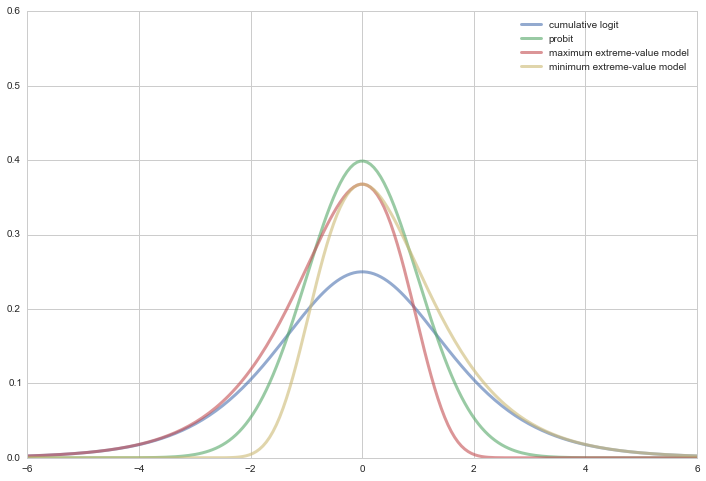

In [2]:
# pdfs for the different choices of epsilon
%matplotlib inline
from scipy.stats import logistic, norm, gumbel_l
import seaborn as sns
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8, forward=True)
x = np.linspace(-6, 6, 200)
ax.plot(x, logistic.pdf(x), c=sns.color_palette()[0], lw=3, alpha=0.6, label='cumulative logit')
ax.plot(x, norm.pdf(x), c=sns.color_palette()[1], lw=3, alpha=0.6, label='probit')
ax.plot(x, gumbel_l.pdf(x), c=sns.color_palette()[2], lw=3, alpha=0.6, label='maximum extreme-value model')
ax.plot(x, np.flipud(gumbel_l.pdf(x)), c=sns.color_palette()[4], lw=3, alpha=0.6, label='minimum extreme-value model')
plt.legend()
plt.ylim([0, 0.6])
plt.savefig('epsdf.png', dpi=200)

Whereas the probit and logit model are a good choice for symmetric errors, the Gumbel and reversed Gumbel distribution can be used for the case of asymmetric error distributions to provide a better fit. For many cases, a certain assymetry regarding the error is quite natural.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


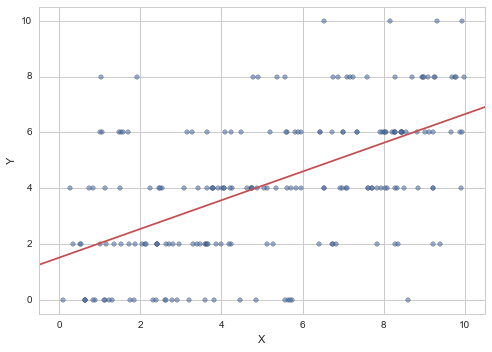

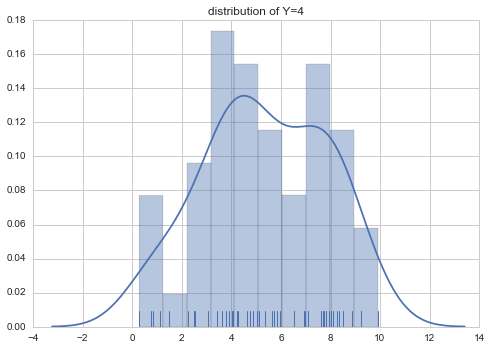

In [3]:
### An example where linear regression fails
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set_style("whitegrid")

# generate some data
N = 200
X = np.random.uniform(0., 10., size=N)
# this is done to have just some random samples, no probit intuition
Y = 2 * np.abs(np.ceil(0.25 * X + np.random.gamma(0.25, size=X.shape[0]) + np.random.normal(size=X.shape[0])))

plt.scatter(X, Y, c=sns.color_palette()[0], alpha=.6)

# fit linear regression to data
x = sm.add_constant(X)
results = sm.OLS(Y, x).fit()
# plot line on top
yreg = results.params[1] * np.arange(-1, 12)  + results.params[0]
plt.plot(np.arange(-1, 12), yreg, c=sns.color_palette()[2])
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([-0.5, 10.5])
plt.ylim([-0.5, 10.5])
plt.savefig('img/orddata_.png', dpi=200)

# now empirical cdf for values at Y==4
plt.figure()
vals = X[np.where(Y == 4)]
sns.distplot(vals, rug=True, bins=10);
plt.title('distribution of Y=4')
plt.savefig('img/val4_.png', dpi=200)

## Fitting the model

Assume we are given $N$ datapoints $(Y_1, X_1), ..., (Y_N, X_N)$ with $Y_i \in \lbrace 1, ..., R \rbrace, \quad X_i \in \mathbb{R}^L$ (independence assumption as usual(errors)). We simplify the fitting process, by using predefined boundaries $\beta$. Of course it is also possible to put a prior on $\beta$ and include it in the optimization approach but to do so, additional constraints need to be satisfied (i.e. $-\infty = \beta_0 < 1 < \beta_1 < 2 < ... < \beta_{R-1} < R < \beta_R = \infty$). One easy way to define the bounds is to use the middle, i.e.
$\beta_r = r - 0.5 \quad \text{for} \quad r = 1, ..., R-1$. 
Then, the log likelihood function of the data $\mathcal{D} = \lbrace (Y_1, X_1), ..., (Y_N, X_N) \rbrace$ is given as

$$ \mathcal{L}(w \; \vert \; \mathcal{D}, \beta) = \sum_{n=1}^N \log \left( F_\epsilon(\beta_{Y_n} + X_n^T w) - F_\epsilon(\beta_{Y_n-1} + X_n^Tw) \right)$$

### Maximum Likelihood Estimate
this allows us to derive a Maximum Likelihood for the model

$$ \hat{w}_{\mathrm{MLE}} = \underset{w}{\operatorname{argmax}} \mathcal{L}(w \; \vert \; \mathcal{D}, \beta)$$
### Maximum a posteriori estimate
The MAP estimate can be derived by ignoring the normalization constant (cf. properties of an argmax) as 
$$ \hat{w}_{\mathrm{MAP}} = \underset{w}{\operatorname{argmax}} \mathcal{L}(w \; \vert \; \mathcal{D}, \beta) + \log f_w(w)$$

with $f_w$ being the pdf of the choosen prior distribution for $w$. Popular choices are

- Ridge regression: $w \sim \mathcal{N}(0, \tau I)\quad \quad$  (Gaussian prior with diagonal matrix)
- LASSO regression: $w_i \sim \mathrm{Laplace}(0, \tau)\quad \quad$  (Laplace prior, indep. components)

### Implementation notes
One way to solve the optimization problems is to used parallelized stochastic gradient descent as described in
<http://www.research.rutgers.edu/~lihong/pub/Zinkevich11Parallelized.pdf>. I.e. the data is distributed randomly over the nodes (the stoch. gradient shuffle step) and then per node the gradient is computed. To optimize the process, each node should node the same amount of data and the gradient is computed over all data. Thus the 'stochasticness' is done mainly in the shuffle step. After each round of computation results are aggregated by average.

#### General Gradient
$$ 
\begin{split}
\frac{\partial \mathcal{L}(\beta \;\vert\; \mathcal{D}, \theta )}{\partial \beta_j} &= \frac{\partial}{\partial \beta_j} \sum_{i=1}^n \log \left( F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right) \right) \\
&= \sum_{i=1}^n \frac{\partial}{\partial \beta_j} \log \left( F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right) \right) \\
&= \sum_{i=1}^n  \frac{\frac{\partial}{\partial \beta_j}\left[ F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right) \right]}{F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)} \\
&= \sum_{i=1}^n  \frac{f_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right)X_{i,j} - f_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)X_{i,j}}{F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)} \\
&= \sum_{i=1}^n  \frac{f_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - f_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)}{F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)}X_{i,j} \\
&= \sum_{i=1}^n  g(\theta, X_i, Y_i)X_{i,j} \\
\end{split}
$$
With $X_{i,j}$ being the $j$-th component of the vector $X_i$ and $f_\epsilon$ being the density of $\epsilon$

<table>
<tr>
<td>Logistic distribution</td>
<td>$ \mathrm{Logistic}(\mu, s)$</td>
<td>$$ F(x) = \frac{1}{1 + \exp(-\frac{x-\mu}{s})}$$</td>
<td>$$ f(x) = \frac{\exp(-\frac{x-\mu}{s}}{s \left( 1 + \exp{- \frac{x-\mu}{s}}\right)^2}$$</td>
</tr>
<tr>
<td>Normal distribution</td>
<td>$ \mathcal{N}(\mu, \sigma)$</td>
<td>$$ F(x) = \Phi\left(\frac{x - \mu}{\sigma}\right)$$</td>
<td>$$ f(x) = \frac{1}{\sigma}\varphi\left(\frac{x - \mu}{\sigma}\right)$$</td>
</tr>
<tr>
<td>Gumbel distribution (Maximum extreme value)</td>
<td>$ \mathrm{Gumbel}(\mu, \beta)$</td>
<td>$$ F(x) = \exp \left( - \exp \left(- \frac{x - \mu}{\beta} \right) \right)$$</td>
<td>$$ f(x) = \frac{1}{\beta}\exp \left( - \left( \frac{x-\mu}{\beta} + \exp \left( \frac{x - \mu}{\beta}\right) \right) \right)$$</td>
</tr>
<tr>
<td>Flipped Gumbel distribution (Minimum extreme value)</td>
<td>$ -\mathrm{Gumbel}(\mu, \beta)$</td>
<td>$$ F(x) = \exp \left( - \exp \left(- \frac{-x - \mu}{\beta} \right) \right)$$</td>
<td>$$ f(x) = \frac{1}{\beta}\exp \left( - \left( \frac{-x-\mu}{\beta} + \exp \left( \frac{-x - \mu}{\beta}\right) \right) \right)$$</td>
</tr>
</table>

In [4]:
# implementation of the cumulative model (probit case)

# negative log likelihood
def nloglikelihood(X, y, theta, beta):
    llsum = 0.
    
    for i in xrange(X.shape[0]):
        llsum += np.log(norm.cdf(theta[y[i]]) - norm.cdf(theta[y[i]-1]))
    
    return -llsum

# helper function g
def gradient_g(x, yi, theta, beta):
    g = norm.pdf(theta[yi] + np.dot(x, beta)) - norm.pdf(theta[yi - 1] + np.dot(x, beta)) / \
    (norm.cdf(theta[yi] + np.dot(x, beta)) - norm.cdf(theta[yi - 1] + np.dot(x, beta)))
    return g

# negative log likelihood gradient
def nloglikelihood_gradient(X, y, theta, beta):
    grad = 0
    # more than one sample
    if len(X.shape) > 1:
        grad = np.zeros(X.shape[1])
        for i in xrange(X.shape[0]):
            grad += gradient_g(X[i, :], y[i], theta, beta)
    else:
        grad = gradient_g(X, y, theta, beta) * X
            
    return -grad
    
# stochastic gradient descent
def sgd(X, y, theta, beta0, learning_rate = 0.05, num_epochs=1):
    
    beta = beta0.copy()
    N = X.shape[0]
    for epoch in xrange(num_epochs):
        
        # randomly shuffle data
        permutation = np.random.choice(range(N), N, replace = False)
        
        # update using all ratings (minibatch size = 1)
        for i in xrange(N):
            # use here in a later version momentum
            idx = permutation[i]
            beta -= learning_rate * nloglikelihood(X[idx, :], y[idx], theta, beta)
        

### Example: Predicting the rating based on 'words'
One possibility to predict a rating is to use actual contents. This could be for a the Jester joke dataset the actual joke with its wording, or given restaurant reviews its wording (i.e. relative word count). These can be either used as binary features (if some popular word exists) or as relative / absolute count.


#### Links:
- <http://www.cambridge.org/de/academic/subjects/statistics-probability/statistical-theory-and-methods/regression-categorical-data>
- <http://fa.bianp.net/blog/2013/logistic-ordinal-regression/>
- <http://arxiv.org/pdf/1408.2327v6.pdf>
- <http://www.stat.ufl.edu/~aa/ordinal/agresti_ordinal_tutorial.pdf>
- <http://onlinelibrary.wiley.com/book/10.1002/9780470594001>

### A versatile model

In the following, a general model is developed to model ratings. Therefore, the following variables are introduced
<table>
<tr>
<td><b>variable</b></td><td><b>meaning</b></td>
</tr>
<tr>
<td>$N$</td><td>number of data samples $n=1, ..., N$</td>
</tr>
<tr>
<td>$K$</td><td>number of latent variables per user and item</td>
</tr>
<tr>
<td>$L$</td><td>number of features describing each item</td>
</tr>
<tr>
<td>$I$</td><td>number of users, i.e. we have users $i = 1, ..., I$</td>
</tr>
<tr>
<td>$J$</td><td>number of items, i.e. $j = 1, ..., J$</td>
</tr>
<tr>
<td>$\mathcal{D}$</td><td>data matrix consisting of $N$ rows $D_n$</td>
</tr>
<tr>
<td>$\mathcal{X}$</td><td>feature data matrix consisting of $J$ rows $X_n$</td>
</tr>
<tr>
<td>$X_n$</td><td>$n$th data row, i.e $X_n = (X_{n, 1}, ..., , X_{n, L})^T$ with $X_{n,l} \in \mathbb{R}$</td>
</tr>
<tr>
<td>$D_n$</td><td>$n$th data row, i.e $D_n = (r_n, i_n, j_n)^T$ with $r_n \in \lbrace 1, ..., R\rbrace$ being a rating, $i_n, j_n$ being indices adressing a user and a item</td>
</tr>
<tr>
<td>$R$</td><td>number of ratings, i.e. each rating $r$ has to be $\in \lbrace 1, ..., R \rbrace$</td>
</tr>
<tr>
<td>$\beta$</td><td>vector describing the buckets, i.e. $-\infty = \beta_0 < 1 < \beta_1 < ... < \beta_{R-1} < R < \beta_R = \infty$</td>
</tr>
</table>

Define now the model using the ordinal regression approach with a latent variable

$$\tilde{Y}_{i, j} = - \left( u_i^Tv_j + X_j^Tw + a_i + b_j + g \right) + \epsilon$$
Let $Y_n := Y_{i_n, j_n}$

The model variables have the following definition/meaning 
<table>
<tr>
<td>$u_i \in \mathbb{R}^K$</td><td>latent variables of user $i$</td>
</tr>
<tr>
<td>$v_j \in \mathbb{R}^K$</td><td>latent variables of item $j$</td>
</tr>
<tr>
<td>$a_i \in \mathbb{R}$</td><td>bias for user $i$</td>
</tr>
<tr>
<td>$b_j \in \mathbb{R}$</td><td>bias of item $j$</td>
</tr>
<tr>
<td>$g \in \mathbb{R}$</td><td>global bias</td>
</tr>
<tr>
<td>$w \in \mathbb{R}^L$</td><td>weights for the $j$th item features</td>
</tr>
</table>

Define $\chi(i,j) := u_i^Tv_j + X_j^Tw + a_i + b_j + g$ and $\chi_n := \chi(i_n, j_n)$

The full model is parametrized via
$$\theta = \begin{pmatrix} u_1 & ... & u_I & v_1 & ... & v_J & a_1 & ... & a_I & b_1 & ... & b_J & g & w \end{pmatrix}^T$$

We can write the loglikelihood as

$$\mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) = \sum_{n=1}^N \log \left( F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n) \right)$$


##### Computing the gradient

The gradient can be computed easily via the standard rules

$$
\begin{split}
\frac{\partial}{\partial u_i} \mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) &= \sum_{n=1}^N \frac{\partial}{\partial u_i} \log \left( F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n) \right) \\
&= \sum_{n \in \lbrace n =1, ..., N \;\vert\; i_n = i\rbrace} \frac{\partial}{\partial u_i} \log \left( F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n) \right)
\end{split}
$$

Let $I_i := \lbrace n =1, ..., N \;\vert\; i_n = i\rbrace, \quad J_j := \lbrace n =1, ..., N \;\vert\; j_n = j\rbrace$ , then

$$
\begin{split}
\frac{\partial}{\partial u_i} \mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) &= \sum_{n \in I_i}  \frac{ \frac{\partial}{\partial u_i}\left( F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n) \right)}{F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n)} \\
&= \sum_{n \in I_i}  \frac{ f_\epsilon(\beta_{Y_n} + \chi_n) - f_\epsilon(\beta_{Y_n - 1} + \chi_n)}{F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n)}\frac{\partial}{\partial u_i} \chi_n
\end{split}
$$

The structure will be always the same, so define
$$ q_n := \frac{ f_\epsilon(\beta_{Y_n} + \chi_n) - f_\epsilon(\beta_{Y_n - 1} + \chi_n)}{F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n)}$$

the gradient of any $\xi$ of the individual components can now be written as

$$ \frac{\partial}{\partial \xi} \mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) = \sum_{n=1}^N q_n \frac{\partial}{\partial \xi}\chi_n$$
(note that for many terms this is zero!)

Given

$$ \frac{\partial}{\partial u_i}\chi_n = \begin{cases} v_{j_n} \quad n \in I_i \\
0 \quad \text{else}\end{cases}$$
$$ \frac{\partial}{\partial v_j}\chi_n = \begin{cases} u_{i_n} \quad n \in J_j \\
0 \quad \text{else}\end{cases}$$
$$ \frac{\partial}{\partial a_i}\chi_n = \begin{cases} 1 \quad n \in I_i \\
0 \quad \text{else}\end{cases}$$
$$ \frac{\partial}{\partial b_j}\chi_n = \begin{cases} 1 \quad n \in J_j \\
0 \quad \text{else}\end{cases}$$

$$ \frac{\partial}{\partial w}\chi_n = X_{j_n}$$
$$\frac{\partial}{\partial g}\chi_n = 1$$

the gradient of the full model is

$$ \frac{\partial}{\partial \theta} \mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) = \begin{pmatrix} \sum_{n \in I_1}q_n v_{j_n} & ... & \sum_{n \in I_I}q_n v_{j_n} & \sum_{n \in J_1}q_n u_{i_n} & ... & \sum_{n \in J_J}q_n u_{i_n} & \sum_{n \in I_1}q_n & ... & \sum_{n \in I_I}q_n & \sum_{n \in J_1}q_n & ... & \sum_{n \in J_J}q_n & \sum_{n =1, ..., N}q_n & \sum_{n =1, ..., N}q_nX_{j_n} \end{pmatrix}^T$$

## Analysis

In [5]:
df = pd.read_csv('../data/experiments.csv', sep=';', decimal=',')
df['Accuracy'] = df['Accuracy'].apply(lambda x: x.replace(',','.'))
df.head()

,Function,Epochs,Time taken,Accuracy,RMSE
0,norm,1,38.057375,0.4625,2.167602
1,norm,2,68.539290,0.4605,2.138925
2,norm,3,111.779945,0.463,2.146742
3,norm,4,135.670459,0.462,2.139042
4,norm,5,164.142703,0.4615,2.135650


In [6]:
df['Time per Epoch'] = df['Time taken'].astype(float) / df['Epochs'].astype(float)

In [7]:
df.head()

,Function,Epochs,Time taken,Accuracy,RMSE,Time per Epoch
0,norm,1,38.057375,0.4625,2.167602,38.057375
1,norm,2,68.539290,0.4605,2.138925,34.269645
2,norm,3,111.779945,0.463,2.146742,37.259982
3,norm,4,135.670459,0.462,2.139042,33.917615
4,norm,5,164.142703,0.4615,2.135650,32.828541


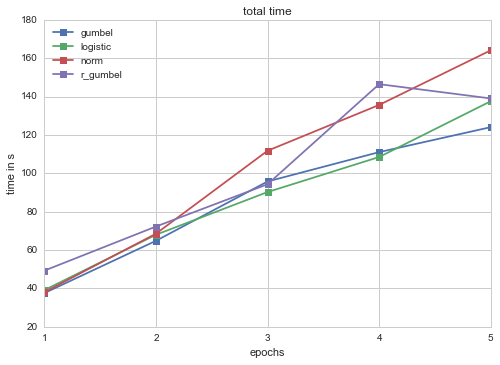

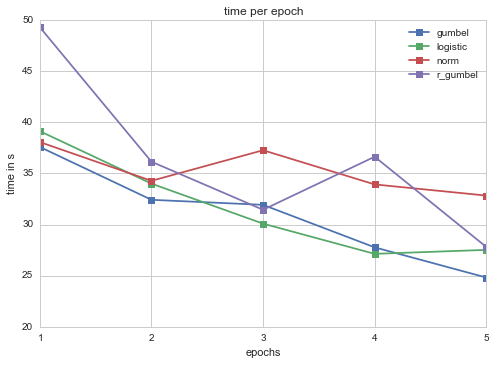

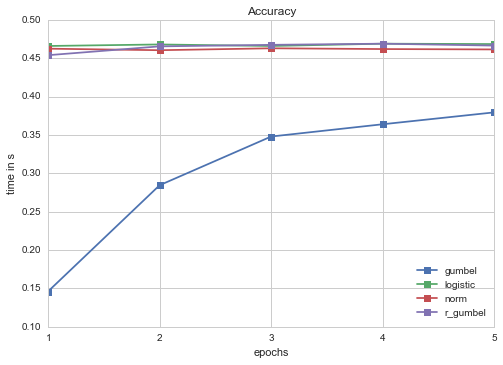

In [8]:
plt.figure()
# plot the time taken for each model type
for key, group in df.groupby('Function'):
    plt.plot(group['Epochs'], group['Time taken'], 's-', label=key)
plt.legend(loc = 'best')
plt.ylabel('time in s')
plt.xlabel('epochs')
plt.xticks(np.arange(1, 6, 1))
plt.title('total time')
plt.savefig('img/time.png', dpi=200)

plt.figure()
# plot the time taken for each model type
for key, group in df.groupby('Function'):
    plt.plot(group['Epochs'], group['Time per Epoch'], 's-', label=key)
plt.legend(loc = 'best')
plt.ylabel('time in s')
plt.xlabel('epochs')
plt.xticks(np.arange(1, 6, 1))
plt.title('time per epoch')
plt.savefig('img/timeperepoch.png', dpi=200)

plt.figure()
# plot accuracy
for key, group in df.groupby('Function'):
    plt.plot(group['Epochs'], group['Accuracy'].astype(float), 's-', label=key)
plt.legend(loc = 'best')
plt.ylabel('time in s')
plt.xlabel('epochs')
plt.xticks(np.arange(1, 6, 1))
plt.title('Accuracy')
plt.savefig('img/accuracy.png', dpi=200)